## CatBoost

In [1]:
import numpy as np 
import pandas as pd
import os
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

### Pre-processing

In [2]:
df = pd.read_csv('train_avito.csv', parse_dates = ['activation_date'])
df.head()

item_id       user_id                 region              city  \
0  b912c3c6a6ad  e00f8ff2eaf9   Свердловская область      Екатеринбург   
1  2dac0150717d  39aeb48f0017      Самарская область            Самара   
2  ba83aefab5dc  91e2f88dd6e3     Ростовская область    Ростов-на-Дону   
3  02996f1dd2ea  bf5cccea572d              Татарстан  Набережные Челны   
4  7c90be56d2ab  ef50846afc0b  Волгоградская область         Волгоград   

  parent_category_name               category_name  \
0          Личные вещи  Товары для детей и игрушки   
1      Для дома и дачи           Мебель и интерьер   
2  Бытовая электроника               Аудио и видео   
3          Личные вещи  Товары для детей и игрушки   
4            Транспорт                  Автомобили   

                       param_1     param_2 param_3                  title  \
0    Постельные принадлежности         NaN     NaN  Кокоби(кокон для сна)   
1                       Другое         NaN     NaN      Стойка для Одежды   
2  Видео, DVD и Blu-ray плееры         NaN     NaN         Philips bluray   
3         Автомобильные кресла         NaN     NaN             Автокресло   
4                   С пробегом  ВАЗ (LADA)    2110         ВАЗ 2110, 2003   

                                         description    price  \
0  Кокон для сна малыша,пользовались меньше месяц...    400.0   
1          Стойка для одежды, под вешалки. С бутика.   3000.0   
2  В хорошем состоянии, домашний кинотеатр с blu ...   4000.0   
3                             Продам кресло от0-25кг   2200.0   
4                           Все вопросы по телефону.  40000.0   

   item_seq_number activation_date user_type  \
0                2      2017-03-28   Private   
1               19      2017-03-26   Private   
2                9      2017-03-20   Private   
3              286      2017-03-25   Company   
4                3      2017-03-16   Private   

                                               image  image_top_1  \
0  d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...       1008.0   
1  79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...        692.0   
2  b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...       3032.0   
3  e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...        796.0   
4  54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...       2264.0   

   deal_probability  
0           0.12789  
1           0.00000  
2           0.43177  
3           0.80323  
4           0.20797

In [3]:
pd.set_option('display.float_format', '{:.2f}'.format)
df.price.describe()

count       1418062.00
mean         316708.09
std        66891542.10
min               0.00
25%             500.00
50%            1300.00
75%            7000.00
max     79501011850.00
Name: price, dtype: float64

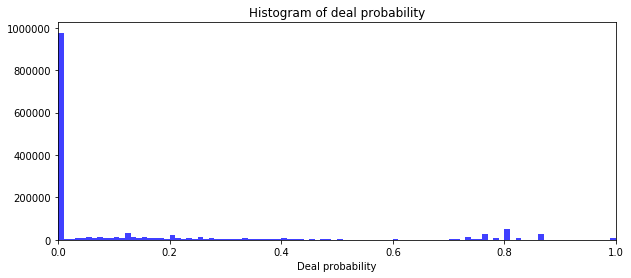

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.float_format', '{:.2f}'.format)
plt.figure(figsize = (10, 4))
n, bins, patches = plt.hist(df['deal_probability'], 100, facecolor='blue', alpha=0.75)
plt.xlabel('Deal probability')
plt.xlim(0, 1)
plt.title('Histogram of deal probability')
plt.show();

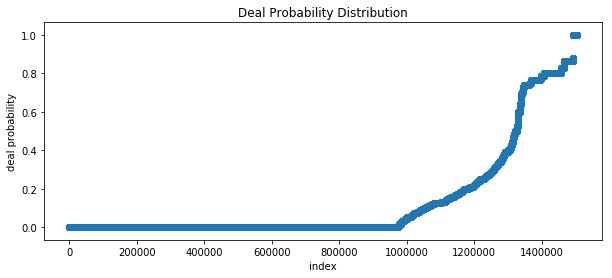

In [5]:
plt.figure(figsize = (10, 4))
plt.scatter(range(df.shape[0]), np.sort(df['deal_probability'].values))
plt.xlabel('index')
plt.ylabel('deal probability')
plt.title("Deal Probability Distribution")
plt.show();

Almost one million Ads has 0 probaility, which means it did not sell anything, and few ads have a probability of 1 which means it did sell something. The other ads have a probability in between 0 and 1. 

### Feature engineering

In [11]:
null_value_stats = df.isnull().sum()
null_value_stats[null_value_stats != 0]

param_1         61576
param_2        654542
param_3        862565
description    116276
image          112588
image_top_1    112588
dtype: int64

Fill missing features with -999, by filling missing values out of their distributions, the model would be able to easily distinguish between them and take it into account.

In [12]:
df.fillna(-999, inplace=True)

Create date time features.

In [14]:
df['year'] = df['activation_date'].dt.year
df['day_of_year'] = df['activation_date'].dt.dayofyear
df['weekday'] = df['activation_date'].dt.weekday
df['week_of_year'] = df['activation_date'].dt.week
df['day_of_month'] = df['activation_date'].dt.day
df['quarter'] = df['activation_date'].dt.quarter

df.drop('activation_date', axis=1, inplace=True)

In [15]:
df.columns

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'user_type', 'image',
       'image_top_1', 'deal_probability', 'year', 'day_of_year', 'weekday',
       'week_of_year', 'day_of_month', 'quarter'],
      dtype='object')

our features are of differnt types - some of them are numeric, some are categorical, and some are text such as title and description, and we could treat these text features just as categorical features.

In [22]:
categorical = ['item_id', 'user_id', 'region', 'city', 'parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3', 'title', 'description', 'item_seq_number', 'user_type', 'image', 'image_top_1']

In [73]:
# lbl = preprocessing.LabelEncoder()
# for col in categorical: 
#    df[col] = lbl.fit_transform(df[col].astype(str))

In [74]:
df.head(3)

item_id  user_id  region  city  parent_category_name  category_name  \
0  1087111   675853      19   460                     4             42   
1   267623   173962      17  1300                     2             22   
2  1095557   440069      16  1276                     0              2   

   param_1  param_2  param_3   title   ...     user_type    image  \
0      249        0        0  298998   ...             1  1135701   
1      122        0        0  676606   ...             1   661422   
2       84        0        0   79843   ...             1   999242   

   image_top_1  deal_probability  year  day_of_year  weekday  week_of_year  \
0           13           0.12789  2017           87        1            13   
1         2722           0.00000  2017           85        6            12   
2         2260           0.43177  2017           79        0            12   

   day_of_month  quarter  
0            28        1  
1            26        1  
2            20        1  

[3 rows x 23 columns]

In [17]:
X = df.drop('deal_probability', axis=1)
y = df.deal_probability

In [18]:
# Prepare Categorical features indices
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]


categorical_features_indices = column_index(X, categorical)

In [19]:
categorical_features_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15], dtype=int64)

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [21]:
model=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_valid, y_valid),plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2858681	test: 0.2853937	best: 0.2853937 (0)	total: 3.29s	remaining: 2m 41s
1:	learn: 0.2780544	test: 0.2775383	best: 0.2775383 (1)	total: 5.7s	remaining: 2m 16s
2:	learn: 0.2714314	test: 0.2709142	best: 0.2709142 (2)	total: 8.59s	remaining: 2m 14s
3:	learn: 0.2659673	test: 0.2654333	best: 0.2654333 (3)	total: 11.5s	remaining: 2m 12s
4:	learn: 0.2611966	test: 0.2606643	best: 0.2606643 (4)	total: 14.1s	remaining: 2m 7s
5:	learn: 0.2574038	test: 0.2568564	best: 0.2568564 (5)	total: 17.3s	remaining: 2m 7s
6:	learn: 0.2541006	test: 0.2535551	best: 0.2535551 (6)	total: 18.1s	remaining: 1m 50s
7:	learn: 0.2513629	test: 0.2508195	best: 0.2508195 (7)	total: 19.7s	remaining: 1m 43s
8:	learn: 0.2490407	test: 0.2484664	best: 0.2484664 (8)	total: 22.5s	remaining: 1m 42s
9:	learn: 0.2470872	test: 0.2465007	best: 0.2465007 (9)	total: 23.3s	remaining: 1m 33s
10:	learn: 0.2454546	test: 0.2448721	best: 0.2448721 (10)	total: 24.8s	remaining: 1m 28s
11:	learn: 0.2441198	test: 0.2435209	best: 0

In [9]:
# df['price'] = np.log(df['price'] + 0.001)

### CatBoost model training

* Iterations is maximum number of trees that can be built when solving machine learning problems.

* learning_rate is used for reducing the gradient step.

* Depth is the depth of the tree. Any integer up to  16 when using CPU. 

* We calculate RMSE as metric.

* bagging_temperature defines the settings of the Bayesian bootstrap, the higher the value the more aggressive the bagging is. We do not want it high.

* We will use the overfitting detector, so, if overfitting occurs, CatBoost can stop the training earlier than the training parameters dictate. And the type of the overfitting detector is "Iter". 

* metric_period is the frequency of iterations to calculate the values of objectives and metrics.

* od_wait, Consider the model overfitted and stop training after the specified number of iterations (100) since the iteration with the optimal metric value.

* eval_set is the validation dataset for overfitting detector, best iteration selection and monitoring metrics' changes.

* use_bset_model = True if a validation set is input (the eval_set parameter is defined) and at least one of the label values of objects in this set differs from the others.

In [23]:
model =  CatBoostRegressor(iterations=700,
                             learning_rate=0.01,
                             depth=16,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)
model.fit(X_train, y_train,
                 eval_set=(X_valid, y_valid),
                 cat_features=categorical_features_indices,
                 use_best_model=True)

0:	learn: 0.2939829	test: 0.2934699	best: 0.2934699 (0)	total: 35.6s	remaining: 6h 55m 4s
75:	learn: 0.2470605	test: 0.2465756	best: 0.2465756 (75)	total: 53m 22s	remaining: 7h 18m 11s
150:	learn: 0.2335739	test: 0.2334741	best: 0.2334741 (150)	total: 1h 46m 25s	remaining: 6h 26m 57s
225:	learn: 0.2284714	test: 0.2285134	best: 0.2285134 (225)	total: 2h 37m 43s	remaining: 5h 30m 48s
300:	learn: 0.2262009	test: 0.2265418	best: 0.2265418 (300)	total: 3h 21m 44s	remaining: 4h 27m 25s
375:	learn: 0.2238186	test: 0.2253192	best: 0.2253192 (375)	total: 4h 7m 2s	remaining: 3h 32m 52s
450:	learn: 0.2223908	test: 0.2245667	best: 0.2245667 (450)	total: 4h 53m 35s	remaining: 2h 42m 5s
525:	learn: 0.2213835	test: 0.2240747	best: 0.2240747 (525)	total: 5h 42m 2s	remaining: 1h 53m 8s
600:	learn: 0.2204280	test: 0.2237288	best: 0.2237288 (600)	total: 6h 29m 49s	remaining: 1h 4m 12s
675:	learn: 0.2194643	test: 0.2234397	best: 0.2234397 (675)	total: 7h 16m 55s	remaining: 15m 30s
699:	learn: 0.2191635	te

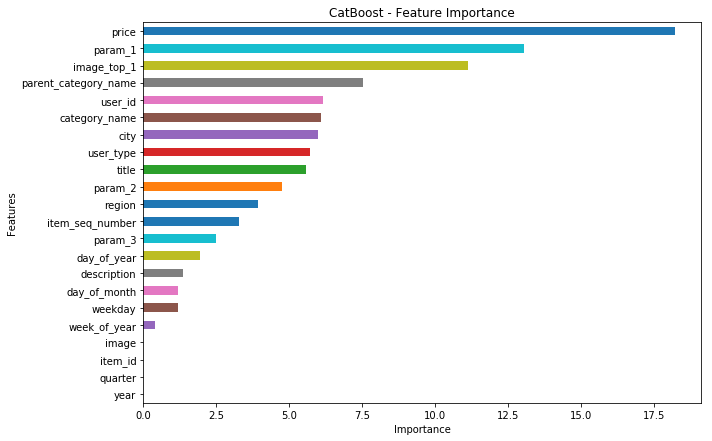

In [24]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [25]:
fea_imp

col   imp
16                  year  0.00
21               quarter  0.00
0                item_id  0.00
14                 image  0.00
19          week_of_year  0.41
18               weekday  1.20
20          day_of_month  1.20
10           description  1.37
17           day_of_year  1.93
8                param_3  2.49
12       item_seq_number  3.28
2                 region  3.92
7                param_2  4.74
9                  title  5.59
13             user_type  5.71
3                   city  6.00
5          category_name  6.08
1                user_id  6.16
4   parent_category_name  7.52
15           image_top_1 11.12
6                param_1 13.06
11                 price 18.23

In [26]:
# model evaluation
from sklearn.metrics import mean_squared_error
print('Model evaluation:')
print(model.get_params())
print('RMSE:', np.sqrt(mean_squared_error(y_valid, model.predict(X_valid))))

Model evaluation:
{'bagging_temperature': 0.2, 'eval_metric': 'RMSE', 'metric_period': 75, 'random_seed': 42, 'od_type': 'Iter', 'od_wait': 100, 'loss_function': 'RMSE', 'depth': 16, 'learning_rate': 0.01, 'iterations': 700}
RMSE: 0.22336364763


## LightGBM

In [1]:
import time
import gc
import random
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
import lightgbm as lgb
import matplotlib.pyplot as plt
import string
%matplotlib inline

In [2]:
import lightgbm as lgb

df = pd.read_csv('train_avito.csv', parse_dates = ['activation_date'])
df['year'] = df['activation_date'].dt.year
df['day_of_year'] = df['activation_date'].dt.dayofyear
df['weekday'] = df['activation_date'].dt.weekday
df['week_of_year'] = df['activation_date'].dt.week
df['day_of_month'] = df['activation_date'].dt.day
df['quarter'] = df['activation_date'].dt.quarter

df.drop('activation_date', axis=1, inplace=True)

In [3]:
df.drop('image', axis=1, inplace=True)

In [4]:
y = df['deal_probability'].values

In [5]:
df.head(3)

item_id       user_id                region            city  \
0  b912c3c6a6ad  e00f8ff2eaf9  Свердловская область    Екатеринбург   
1  2dac0150717d  39aeb48f0017     Самарская область          Самара   
2  ba83aefab5dc  91e2f88dd6e3    Ростовская область  Ростов-на-Дону   

  parent_category_name               category_name  \
0          Личные вещи  Товары для детей и игрушки   
1      Для дома и дачи           Мебель и интерьер   
2  Бытовая электроника               Аудио и видео   

                       param_1 param_2 param_3                  title  \
0    Постельные принадлежности     NaN     NaN  Кокоби(кокон для сна)   
1                       Другое     NaN     NaN      Стойка для Одежды   
2  Видео, DVD и Blu-ray плееры     NaN     NaN         Philips bluray   

    ...    item_seq_number  user_type  image_top_1 deal_probability  year  \
0   ...                  2    Private       1008.0          0.12789  2017   
1   ...                 19    Private        692.0          0.00000  2017   
2   ...                  9    Private       3032.0          0.43177  2017   

   day_of_year  weekday  week_of_year  day_of_month  quarter  
0           87        1            13            28        1  
1           85        6            12            26        1  
2           79        0            12            20        1  

[3 rows x 22 columns]

In [6]:
categorical = ["user_id", "region","city", "parent_category_name", "category_name", "user_type", "image_top_1", "param_1", "param_2", "param_3"]
# Fill NA values for image_top_1 with -1
df["image_top_1"].fillna(-1, inplace=True)

label_encoder = preprocessing.LabelEncoder()
for col in categorical:
    df[col].fillna("unknown")
    df[col] = label_encoder.fit_transform(df[col].astype(str))

In [7]:
df["price"].fillna(df.price.median(), inplace=True)
df["price"] = np.log1p(df["price"])

In [8]:
df.columns

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'user_type', 'image_top_1',
       'deal_probability', 'year', 'day_of_year', 'weekday', 'week_of_year',
       'day_of_month', 'quarter'],
      dtype='object')

In [9]:
df.drop(['item_id', 'title', 'description'], axis=1, inplace=True)
X = df.loc[:, df.columns != 'deal_probability']

In [10]:
feature_names = X.columns.tolist()
print("Number of featues: ", len(feature_names))

Number of featues:  18


### lightGBM model training

In [11]:
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 200,
    'max_depth': 15,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.6,
    'verbosity' : -1
}

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42)
    
# LightGBM dataset formatting 
lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=feature_names,
                categorical_feature = categorical)
lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=feature_names,
                categorical_feature = categorical)
del X, X_train
gc.collect()

44

In [13]:
lgb_clf = lgb.train(
    params,
    lgtrain,
    num_iterations=20000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=["train", "valid"],
    early_stopping_rounds=500,
    verbose_eval=500
)
print("RMSE of the validation set:", np.sqrt(mean_squared_error(y_valid, lgb_clf.predict(X_valid))))

C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\SusanLi\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	train's rmse: 0.219561	valid's rmse: 0.224314
[1000]	train's rmse: 0.216259	valid's rmse: 0.223433
[1500]	train's rmse: 0.214056	valid's rmse: 0.223106
[2000]	train's rmse: 0.212158	valid's rmse: 0.22292
[2500]	train's rmse: 0.210293	valid's rmse: 0.22278
[3000]	train's rmse: 0.208684	valid's rmse: 0.222705
[3500]	train's rmse: 0.207132	valid's rmse: 0.222644
[4000]	train's rmse: 0.205718	valid's rmse: 0.222613
[4500]	train's rmse: 0.204391	valid's rmse: 0.222597
Early stopping, best iteration is:
[4345]	train's rmse: 0.204802	valid's rmse: 0.222595
RMSE of the validation set: 0.222595150292


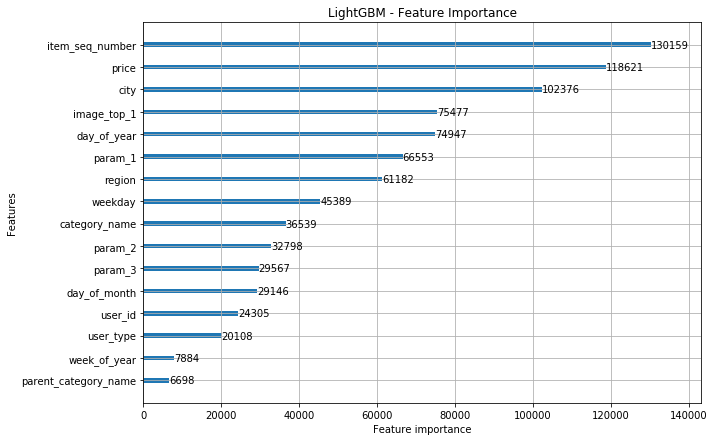

In [15]:
fig, ax = plt.subplots(figsize=(10, 7))
lgb.plot_importance(lgb_clf, max_num_features=30, ax=ax)
plt.title("LightGBM - Feature Importance");